In [1]:
import numpy as np
import jax.numpy as jnp
from pathlib import Path
from importlib import reload

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# figure aesthetics
plt.style.use(["../utils/dark.mplstyle","../utils/notebook.mplstyle"])  # for dark themes
# plt.style.use(["../utils/notebook.mplstyle"])  # for light theme

cdata, cslow, cfast = 'C0', 'C1', 'C2'

In [3]:
# custom libraries
import sys, os

sys.path.append(os.path.abspath('../../spaths'))
import spaths

sys.path.append(os.path.abspath('..'))
import utils.dmaps as dmaps
from utils.mpl_utils import coord_grid

In [4]:
lam = 1.0e+0
eta = 1.0e+0
gam = 1.0e+0
sig = 0.5e+0

eps = 1.0e-2

In [5]:
def drif(t, x, dx):
    y1, y2, z = x
    
    dx[0] = lam*y1 - eta*y2 - gam*y1*z
    dx[1] = eta*y1 + lam*y2 - gam*y2*z
    dx[2] = (y1**2 + y2**2 - z) / eps

def disp(t, x, dx):
    dx[0] = sig
    dx[1] = sig
    dx[2] = sig / np.sqrt(eps)

sde = spaths.ItoSDE(drif, disp)

In [6]:
# seed setting and solver
seed = 3579
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [7]:
# simulation params
dt = .3 * eps
x0 = 0.0, 0.0, 0.0
tspan = (0.0, 200.0)

In [8]:
ens0 = np.array([x0])
ens0.shape

(1, 3)

In [9]:
sol = em.solve(sde, ens0, tspan, dt)

In [10]:
times = sol.t
path = sol.p[0]

In [11]:
path.shape

(66668, 3)

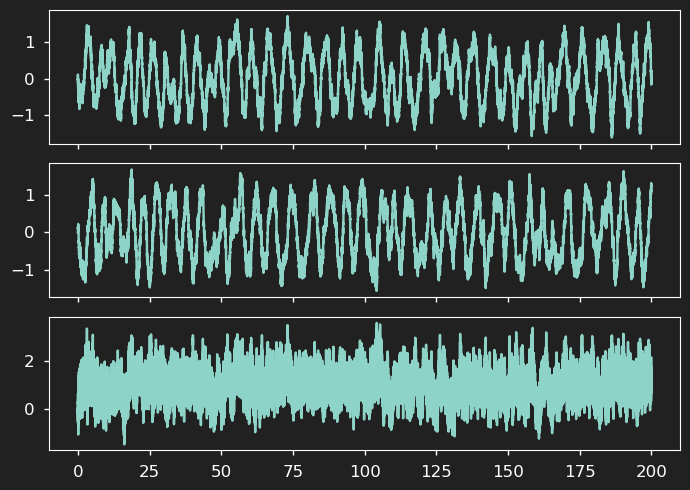

In [12]:
fig, axs = plt.subplots(nrows=len(path.T), sharex=True)
for p, ax in zip(path.T, axs):
    ax.plot(times, p)

fig.tight_layout()
plt.show(fig)
plt.close(fig)

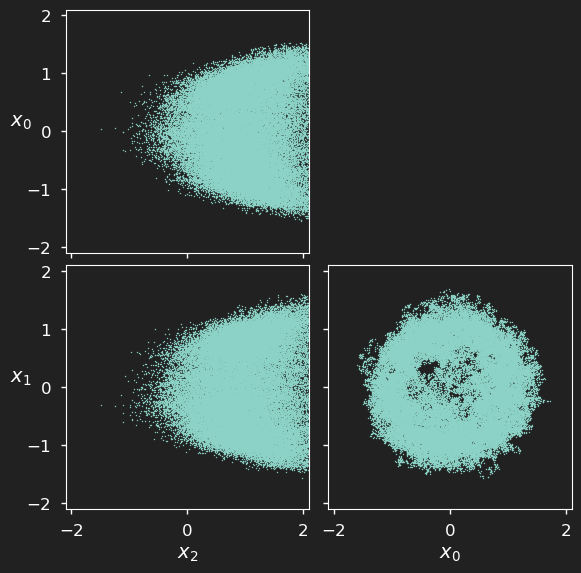

In [13]:
fig = plt.figure(figsize=(10,10))

gs = coord_grid(fig, path, xylim=[-2.1, 2.1])

plt.show(fig)
plt.close(fig)

In [14]:
x, y, z = path.T
r = np.sqrt(x**2 + y**2)

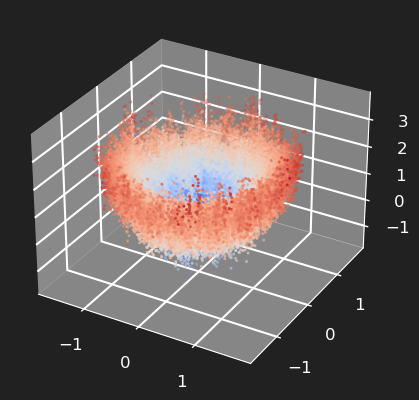

In [15]:
fig = plt.figure()

# Create 3D container
ax = plt.axes(projection = '3d')

ax.scatter3D(x, y, z, s=3, c=r)

plt.show()

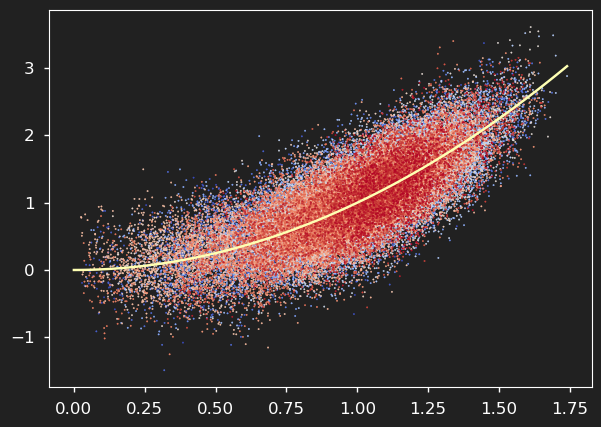

In [16]:
plt.scatter(r, z, s=1, c=times)
# plt.xlim([0, 30])
# plt.ylim([0,1000])

r_max = np.max(r)
r_lin = np.linspace(0, r_max, 100)
plt.plot(r_lin, r_lin**2, c='C1');

plt.show()

## Density plot

In [17]:
y1, y2, z = path[::5].T

In [18]:
r = np.sqrt(y1**2 + y2**2)

In [19]:
zn = z / 10

In [20]:
from sklearn.neighbors import KernelDensity

max_r = np.amax(r)
min_z = np.amin(z)
max_z = np.amax(z)

R, Z = np.meshgrid(np.linspace(0, max_r, 100), np.linspace(min_z, max_z, 200))

RZ = np.vstack([R.ravel(), Z.ravel()]).T
rz = np.vstack([r, z]).T

In [21]:
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(rz)

v = np.exp(kde.score_samples(RZ))

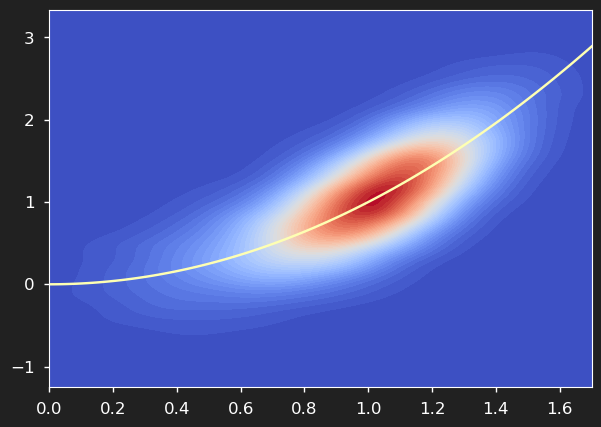

In [22]:
V = v.reshape(R.shape)
plt.contourf(R, Z, V, levels=50)
# plt.scatter(X, Y, s=1)
# plt.scatter(*RZ.T)
r = np.linspace(0, max_r, 100)
plt.plot(r, r**2, c='C1')

plt.show()

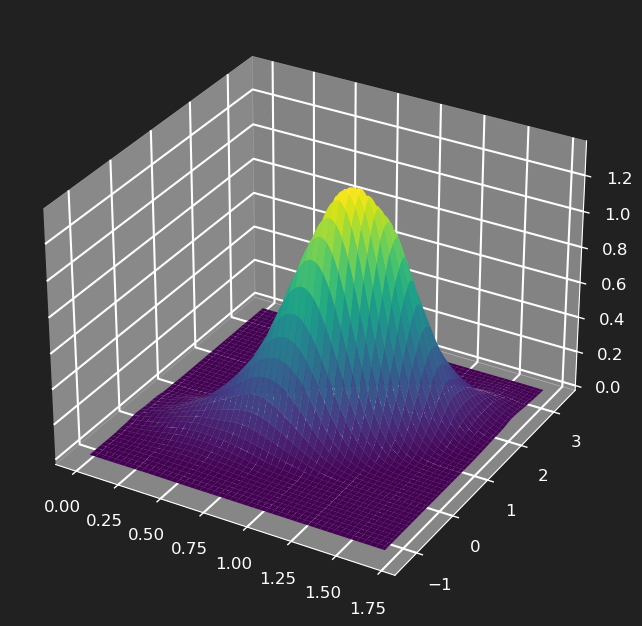

In [23]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

ax.plot_surface(R, Z, V, cmap='viridis');

# Data

In [24]:
data = path[::15]
data.shape

(4445, 3)

In [25]:
y1, y2, z = data.T

In [26]:
r = np.sqrt(y1**2 + y2**2)

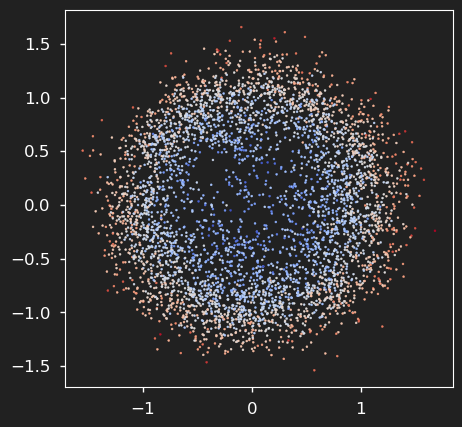

In [27]:
plt.figure(figsize=(5,5))
plt.scatter(y1, y2, c=z, s=2);

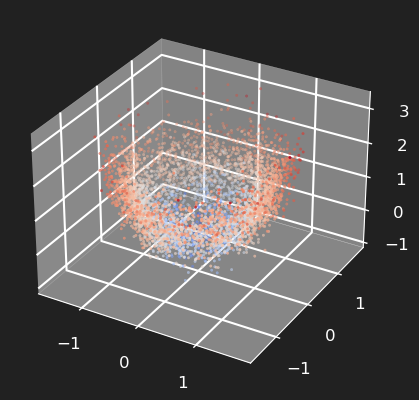

In [28]:
fig = plt.figure()

# Create 3D container
ax = plt.axes(projection = '3d')

ax.scatter3D(*data.T, s=3, c=r)

plt.show()

## Time-scale separation

In [29]:
def eval_lnc(data, sde):
        """
        Computes local noise covaraiances for all instances in data.
        """
        return sde.ens_diff(0, data)

In [30]:
# local noise covaraiances of sde at the data points
ln_covs = eval_lnc(data, sde)
ln_covs.shape

(4445, 3, 3)

In [31]:
e_vals, e_vecs = zip(*[np.linalg.eigh(cov) for cov in ln_covs])  # zip(*) for transposing
e_vals, e_vecs = np.array(e_vals), np.array(e_vecs)

In [32]:
e_vals.shape

(4445, 3)

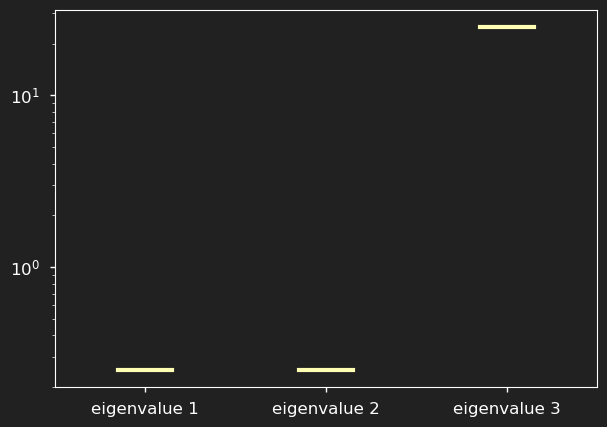

In [33]:
plt.boxplot(e_vals,
            labels=[f"eigenvalue {n+1}" for n in range(e_vals.shape[1])],
            medianprops={'lw': 3})
plt.yscale('log');

## Projection on slow manifold

In [34]:
def slow_proj(data, sde, nreps, tspan, dt):
    nsam, ndim = data.shape
    ens0 = np.repeat(data, nreps, axis=0)
    nsteps = int(tspan[1]/dt)
    bursts = em.burst(sde, ens0, (0, nsteps), dt).reshape(nsam, nreps, ndim)
    return np.nanmean(bursts, axis=1)

In [35]:
sp = slow_proj(data, sde, 2_000, (0, eps*2), dt/4)
sp.shape

(4445, 3)

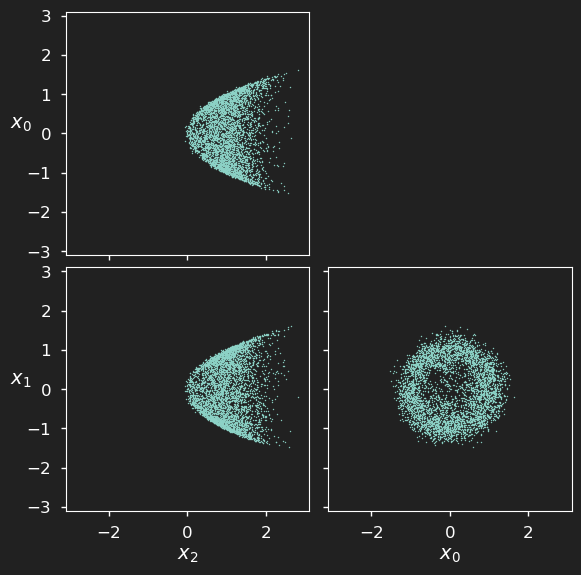

In [36]:
fig = plt.figure(figsize=(10,10))

gs = coord_grid(fig, sp, xylim=[-3.1, 3.1])

plt.show(fig)
plt.close(fig)

In [37]:
sp_y1, sp_y2, sp_z = sp.T

In [38]:
sp_r = np.sqrt(sp_y1**2 + sp_y2**2)

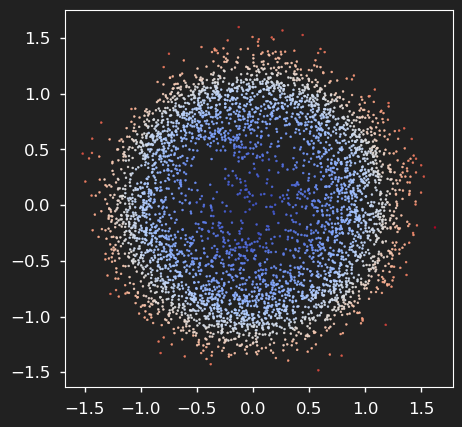

In [39]:
plt.figure(figsize=(5,5))
plt.scatter(sp_y1, sp_y2, c=sp_z, s=2);

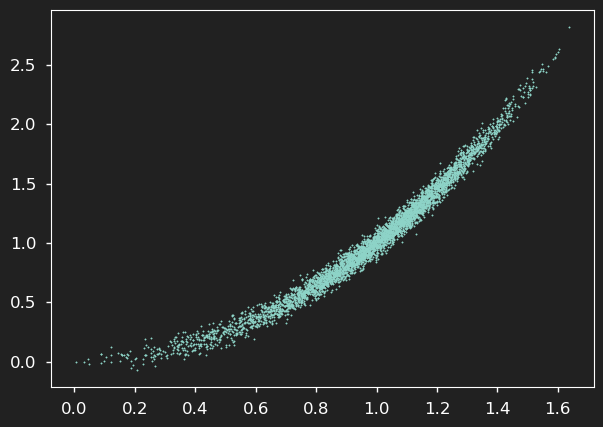

In [40]:
plt.scatter(sp_r, sp_z, s=1)
# plt.xlim([0, 30])
# plt.ylim([0,])

plt.show()

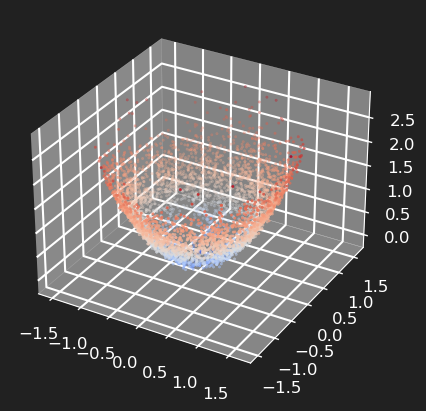

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(sp_y1, sp_y2, sp_z, s=3, c=sp_r)

plt.show()

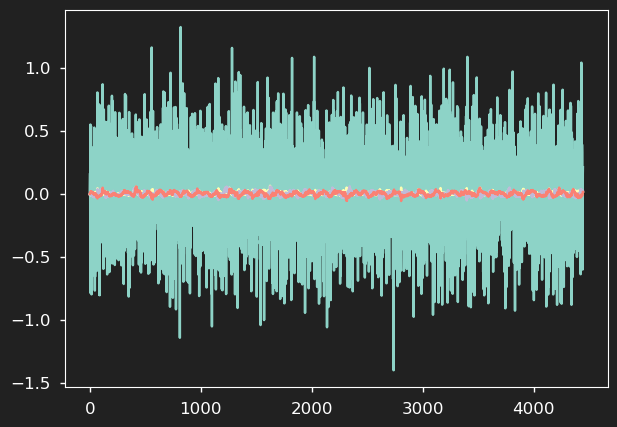

In [45]:
plt.plot(z - sp_z);
plt.plot(r-sp_r)
plt.plot(y1-sp_y1)
plt.plot(y2-sp_y2)

plt.show()